In [1]:
import pickle
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import torch.nn as nn
import torch.optim as optim
from focal_loss.focal_loss import FocalLoss
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler, RandomSampler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
#from autoencoder_utils import *
from joint_utils import *

In [2]:
with open('results/final_models/phi3_joint/metrics_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)


# Access the lists

f1_scores = loaded_data['f1_scores']
auc_scores = loaded_data['auc_scores']
precisions = loaded_data['precisions']
recalls = loaded_data['recalls']
accuracies = loaded_data['accuracies']
matrices = loaded_data['matrices']
fpr_tpr = loaded_data['fpr_tpr']
roc_aucs = loaded_data['roc_aucs']

Class: Fracture
F1 score: 0.48114630467571645
AUC score: 0.5441545039068258
Precision: 0.9382352941176471
Recall: 0.9876160990712074
Accuracy: 0.9273255813953488



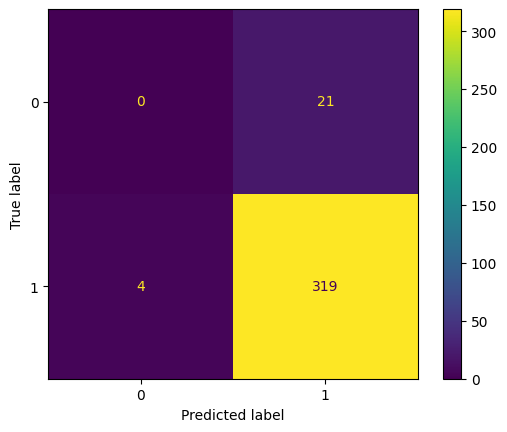

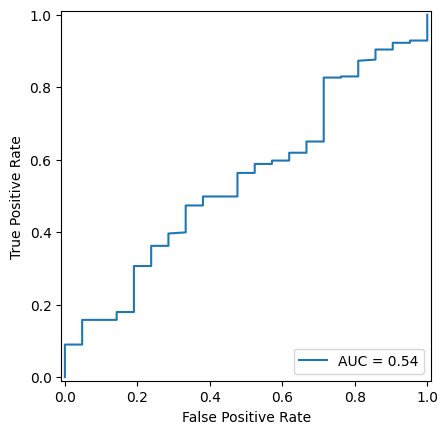

In [3]:
print('Class: Fracture')

print(f'F1 score: {f1_scores[0]}\n'
        f'AUC score: {auc_scores[0]}\n'
        f'Precision: {precisions[0]}\n'
        f'Recall: {recalls[0]}\n'
        f'Accuracy: {accuracies[0]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[0])
matrix.plot()

fpr, tpr = fpr_tpr[0]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[0])
roc_curve.plot()

Class: Lung Lesion
F1 score: 0.4841688654353562
AUC score: 0.672627157129882
Precision: 0.9386189258312021
Recall: 1.0
Accuracy: 0.9386189258312021



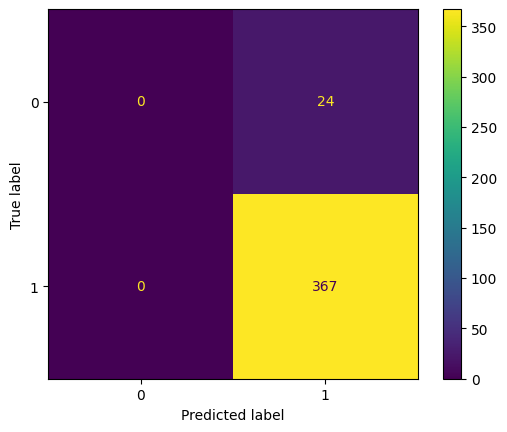

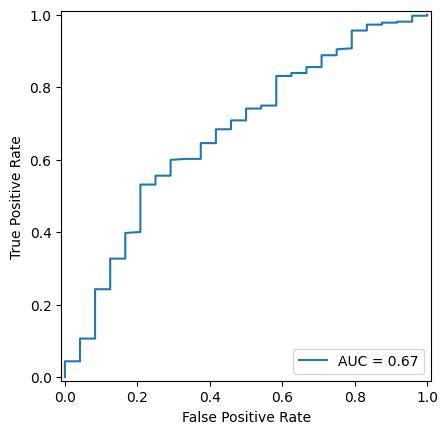

In [4]:
print('Class: Lung Lesion')
print(f'F1 score: {f1_scores[1]}\n'
        f'AUC score: {auc_scores[1]}\n'
        f'Precision: {precisions[1]}\n'
        f'Recall: {recalls[1]}\n'
        f'Accuracy: {accuracies[1]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[1])
matrix.plot()

fpr, tpr = fpr_tpr[1]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[1])
roc_curve.plot()

Class: Enlarged Cardiomediastinum
F1 score: 0.46819582932947296
AUC score: 0.7769019177871391
Precision: 0.7455108359133127
Recall: 0.9958643507030603
Accuracy: 0.7461866992068334



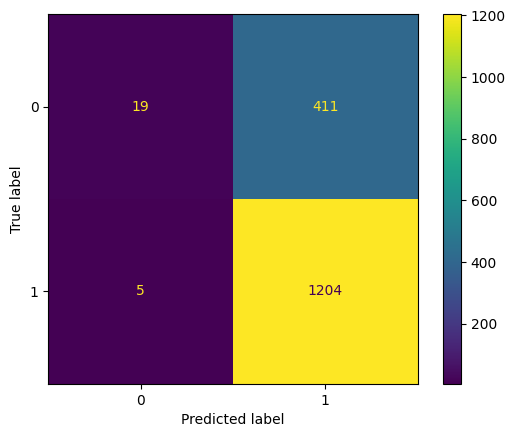

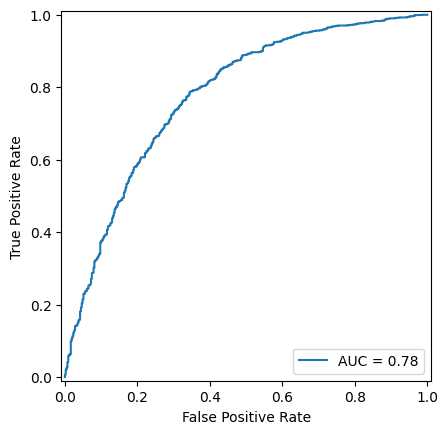

In [11]:
print('Class: Enlarged Cardiomediastinum')
print(f'F1 score: {f1_scores[2]}\n'
        f'AUC score: {auc_scores[2]}\n'
        f'Precision: {precisions[2]}\n'
        f'Recall: {recalls[2]}\n'
        f'Accuracy: {accuracies[2]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[2])
matrix.plot()

fpr, tpr = fpr_tpr[2]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[2])
roc_curve.plot()

Class: Consolidation
F1 score: 0.6172251397311908
AUC score: 0.8354352844151991
Precision: 0.862124248496994
Recall: 0.9949121184088807
Accuracy: 0.862722351121423



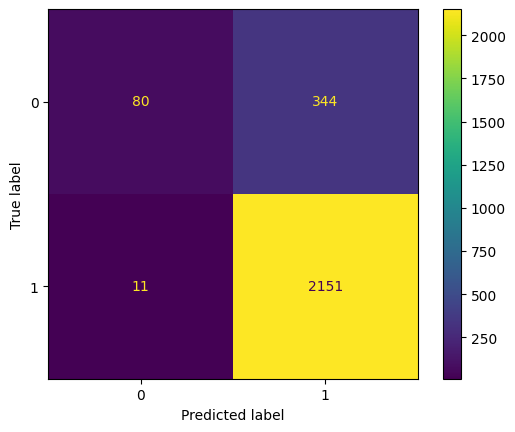

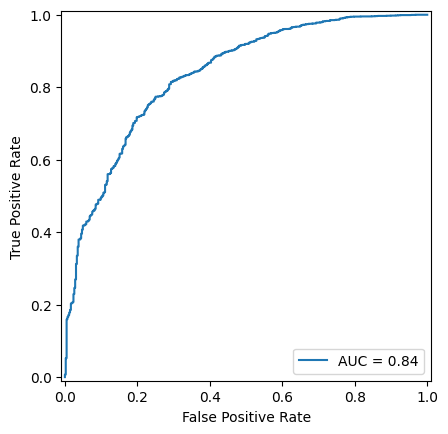

In [5]:
print('Class: Consolidation')
print(f'F1 score: {f1_scores[3]}\n'
        f'AUC score: {auc_scores[3]}\n'
        f'Precision: {precisions[3]}\n'
        f'Recall: {recalls[3]}\n'
        f'Accuracy: {accuracies[3]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[3])
matrix.plot()

fpr, tpr = fpr_tpr[3]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[3])
roc_curve.plot()

Class: Pneumonia
F1 score: 0.5403769275503243
AUC score: 0.8122716837880506
Precision: 0.6018845700824499
Recall: 0.9841116995666828
Accuracy: 0.6332097457627118



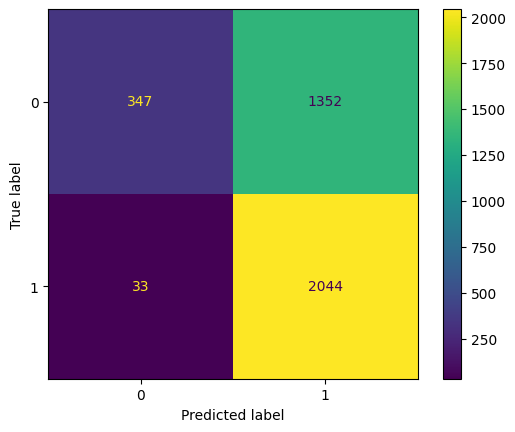

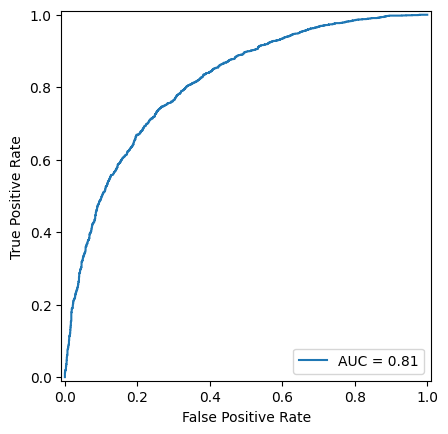

In [6]:
print('Class: Pneumonia')
print(f'F1 score: {f1_scores[4]}\n'
        f'AUC score: {auc_scores[4]}\n'
        f'Precision: {precisions[4]}\n'
        f'Recall: {recalls[4]}\n'
        f'Accuracy: {accuracies[4]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[4])
matrix.plot()

fpr, tpr = fpr_tpr[4]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[4])
roc_curve.plot()

Class: Atelectasis
F1 score: 0.5099912929519396
AUC score: 0.759144496050708
Precision: 0.9763415278879196
Recall: 0.9997293273785357
Accuracy: 0.9760929863954564



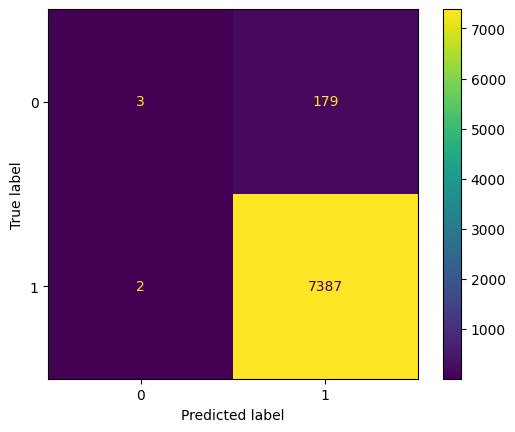

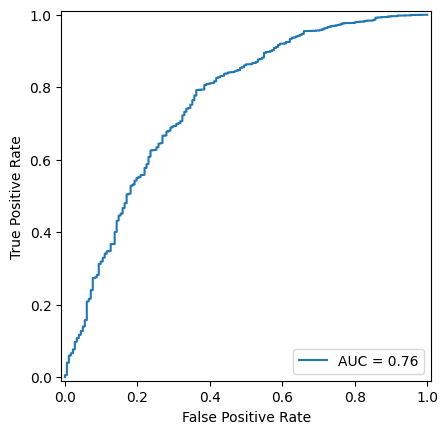

In [7]:
print('Class: Atelectasis')
print(f'F1 score: {f1_scores[5]}\n'
        f'AUC score: {auc_scores[5]}\n'
        f'Precision: {precisions[5]}\n'
        f'Recall: {recalls[5]}\n'
        f'Accuracy: {accuracies[5]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[5])
matrix.plot()

fpr, tpr = fpr_tpr[5]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[5])
roc_curve.plot()

Class: Lung Opacity
F1 score: 0.5088379018095748
AUC score: 0.7540404190873431
Precision: 0.9646888947230244
Recall: 0.9998639455782313
Accuracy: 0.9645855194123819



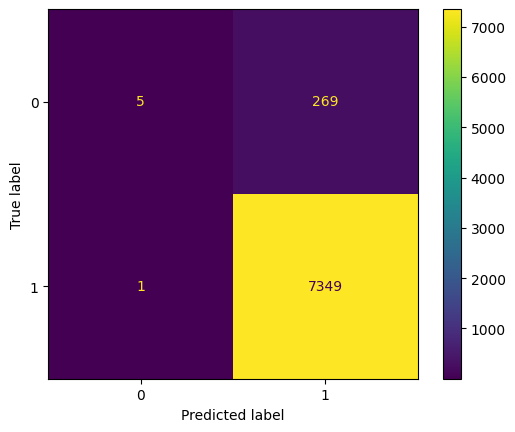

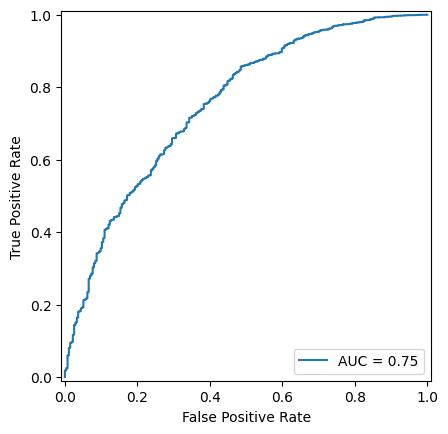

In [8]:
print('Class: Lung Opacity')
print(f'F1 score: {f1_scores[6]}\n'
        f'AUC score: {auc_scores[6]}\n'
        f'Precision: {precisions[6]}\n'
        f'Recall: {recalls[6]}\n'
        f'Accuracy: {accuracies[6]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[6])
matrix.plot()

fpr, tpr = fpr_tpr[6]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[6])
roc_curve.plot()

Class: Pneumothorax
F1 score: 0.5860736143111112
AUC score: 0.7654116899667069
Precision: 0.30069370330843115
Recall: 0.7463576158940397
Accuracy: 0.6459217350306459



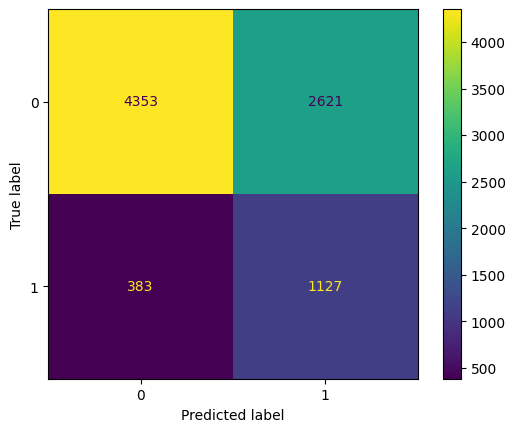

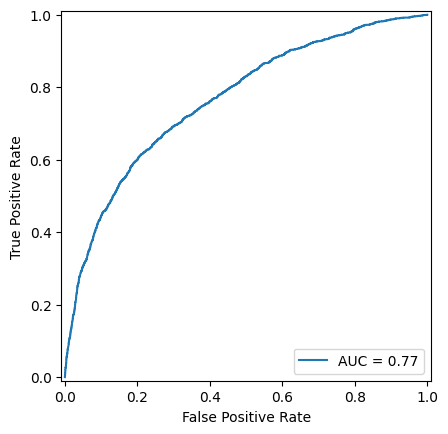

In [9]:
print('Class: Pneumothorax')
print(f'F1 score: {f1_scores[7]}\n'
        f'AUC score: {auc_scores[7]}\n'
        f'Precision: {precisions[7]}\n'
        f'Recall: {recalls[7]}\n'
        f'Accuracy: {accuracies[7]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[7])
matrix.plot()

fpr, tpr = fpr_tpr[7]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[7])
roc_curve.plot()

Class: Edema
F1 score: 0.6239300886029858
AUC score: 0.8574402844909226
Precision: 0.6993435448577681
Recall: 0.9753814852492371
Accuracy: 0.7206145966709347



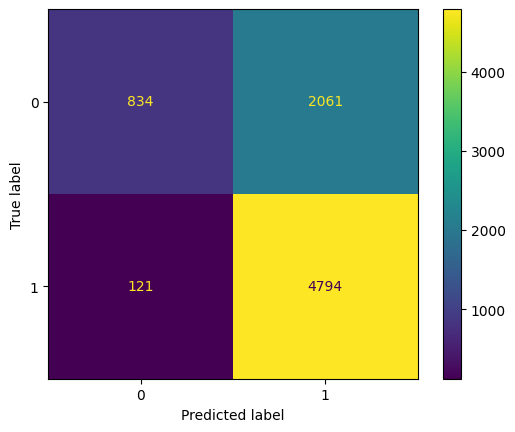

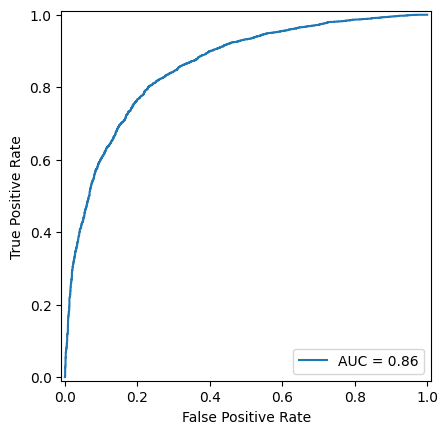

In [10]:
print('Class: Edema')
print(f'F1 score: {f1_scores[8]}\n'
        f'AUC score: {auc_scores[8]}\n'
        f'Precision: {precisions[8]}\n'
        f'Recall: {recalls[8]}\n'
        f'Accuracy: {accuracies[8]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[8])
matrix.plot()

fpr, tpr = fpr_tpr[8]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[8])
roc_curve.plot()

Class: Cardiomegaly
F1 score: 0.6198932352238467
AUC score: 0.8507831318395677
Precision: 0.8419378517249817
Recall: 0.9858186506231199
Accuracy: 0.8385936412160594



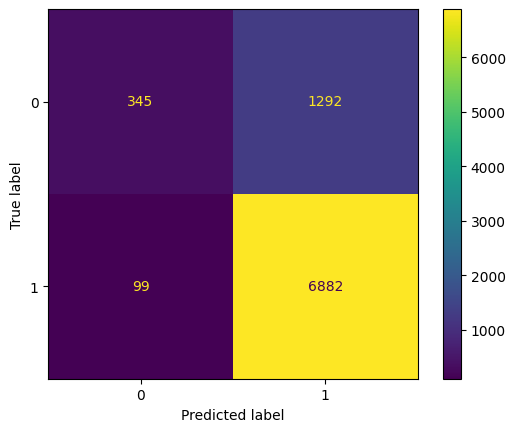

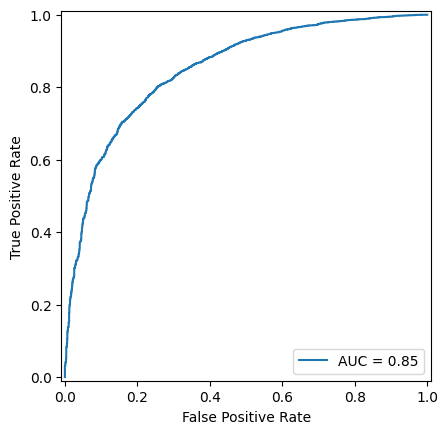

In [12]:
print('Class: Cardiomegaly')
print(f'F1 score: {f1_scores[9]}\n'
        f'AUC score: {auc_scores[9]}\n'
        f'Precision: {precisions[9]}\n'
        f'Recall: {recalls[9]}\n'
        f'Accuracy: {accuracies[9]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[9])
matrix.plot()

fpr, tpr = fpr_tpr[9]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[9])
roc_curve.plot()

Class: Length-of-Stay
F1 score: 0.5734081027889303
AUC score: 0.7710872647840488
Precision: 0.2029029793735676
Recall: 0.6381547333012975
Accuracy: 0.7386507901764217



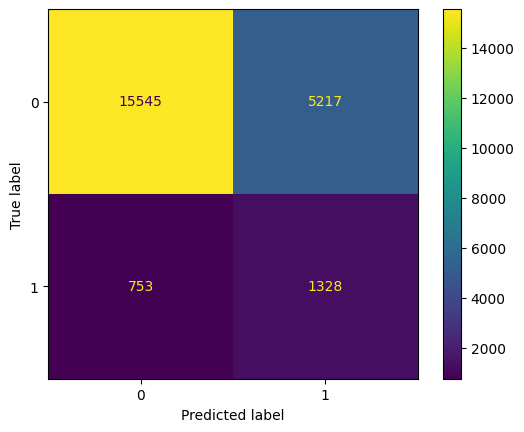

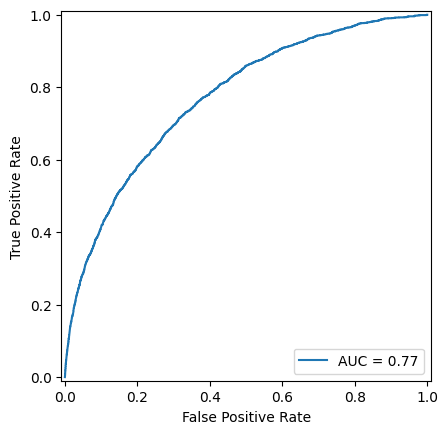

In [13]:
print('Class: Length-of-Stay')
print(f'F1 score: {f1_scores[10]}\n'
        f'AUC score: {auc_scores[10]}\n'
        f'Precision: {precisions[10]}\n'
        f'Recall: {recalls[10]}\n'
        f'Accuracy: {accuracies[10]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[10])
matrix.plot()

fpr, tpr = fpr_tpr[10]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[10])
roc_curve.plot()

Class: 48-hour Mortality
F1 score: 0.582638048209485
AUC score: 0.7823435498445404
Precision: 0.13225371120107962
Recall: 0.417910447761194
Accuracy: 0.9317515212537758



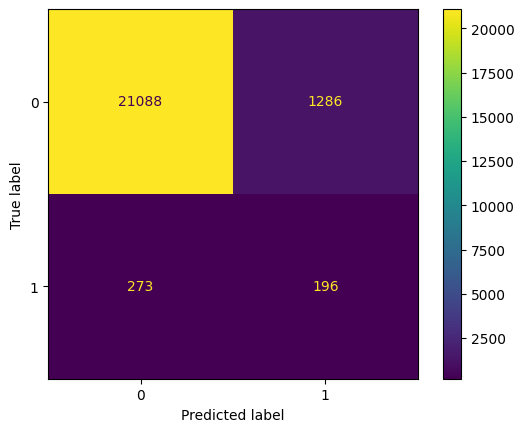

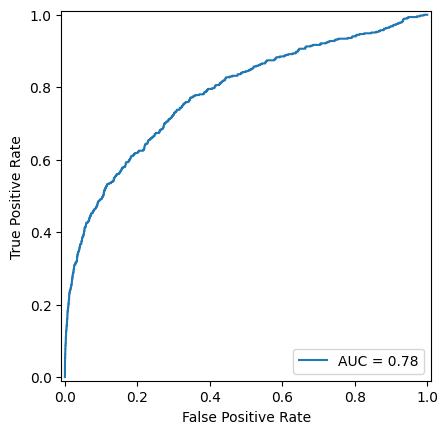

In [14]:
print('Class: 48-hour Mortality')
print(f'F1 score: {f1_scores[11]}\n'
        f'AUC score: {auc_scores[11]}\n'
        f'Precision: {precisions[11]}\n'
        f'Recall: {recalls[11]}\n'
        f'Accuracy: {accuracies[11]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[11])
matrix.plot()

fpr, tpr = fpr_tpr[11]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[11])
roc_curve.plot()